In [102]:
from scipy import signal
import numpy as np
import matplotlib.pylab as plt
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, read

## Estimating time series

Text(0, 0.5, 'Amplitude')

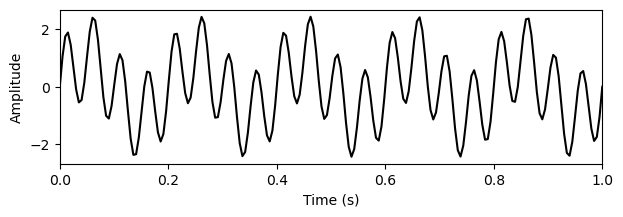

In [132]:
fs = 200  # sampling rate 
t = np.linspace(0, 1, fs)  # time
freq1 = 5 
freq2 = 20 

# 時間域訊號
signal = np.sin(2 * np.pi * freq1 * t) + 1.5 * np.sin(2 * np.pi * freq2 * t)

plt.figure(figsize=(7,2))
plt.plot(t, signal, 'k')
plt.xlim(0,1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

## adding some note
* fft

---

The `sampling theorem` states that at least 2 samples per period are needed to correctly reproduce the highest frequency of a signal. This is the definition of the **Nyquist frequency**: $f_{Ny}=\frac{1}{2\Delta t}= \frac{\Delta f}{2}$ where $\Delta t$ is sampling interval and $\Delta f$ is sampling frequency.


Text(0.5, 0, 'Frequency (Hz)')

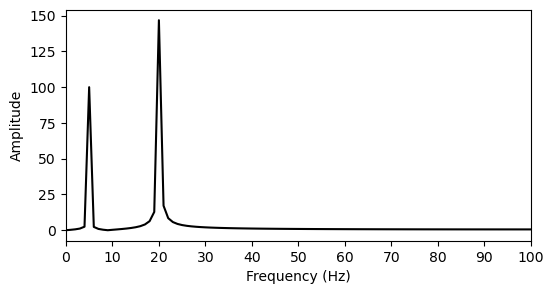

In [133]:
fNy = fs/ 2 
npts = len(t)

spec = np.fft.rfft(signal)
freq = np.linspace(0, fNy, npts // 2 + 1)

plt.figure(figsize=(6,3))
plt.plot(freq, abs(spec), 'k')
plt.xlim(0, fNy)
plt.xticks(range(0, int(fNy+1), 10))
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')


## Seismic waveform spectrum 

In [134]:

st = read('TW.TWGB..BHZ.20240802_222302.mseed')

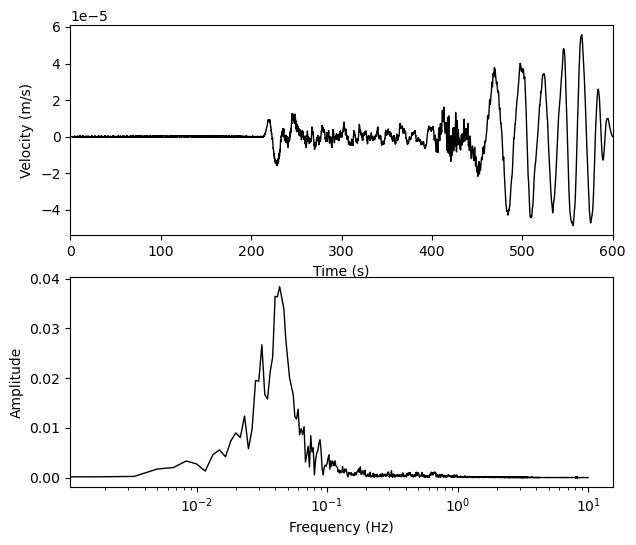

In [135]:
fNy = st[0].stats.sampling_rate / 2
npts = st[0].stats.npts
freq = np.linspace(0, fNy, npts // 2 + 1)

Ospec = np.fft.rfft(st[0].data)

fig, ax = plt.subplots(2,1, figsize=(7,6))
ax[0].plot(st[0].times(), st[0].data, 'k', lw=1)
ax[0].set_xlim(0, 600)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Velocity (m/s)')

ax[1].plot(freq, abs(Ospec), 'k', lw=1)
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_xscale('log')

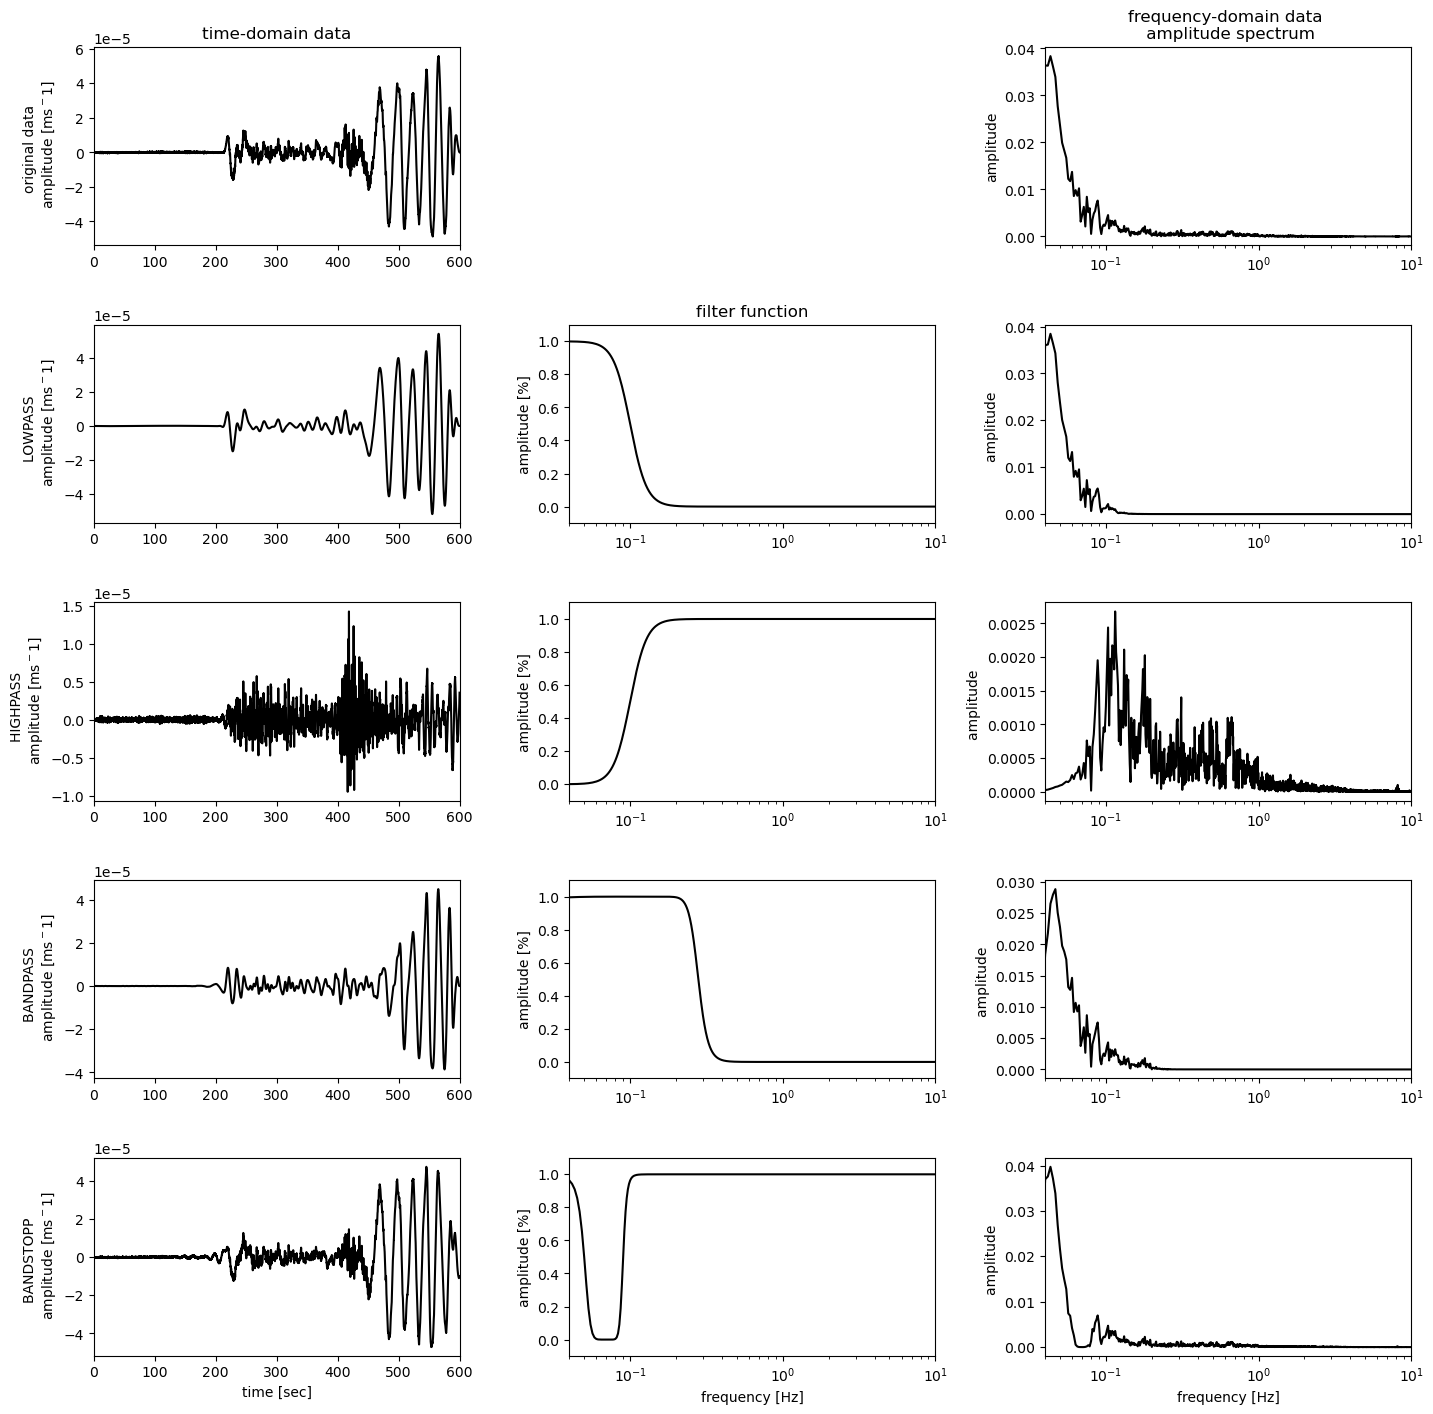

In [136]:
# Cell 2 - filter types
npts = st[0].stats.npts                   # number of samples in the trace
dt = st[0].stats.delta                    # sample interval
fNy = 1. / (2. * dt)                      # Nyquist frequency
time = np.arange(0, npts) * dt            # time axis for plotting
freq = np.linspace(0, fNy, npts // 2 + 1) # frequency axis for plotting
corners = 4                               # order of filter
# several filter frequencies for the different filter types
f0 = 0.1
fmin1 = 0.04
fmax1 = 0.2
fmin2 = 0.06
fmax2 = 0.08

# filter functions
LP = 1 / ( 1 + (freq / f0) ** (2 * corners))
HP = 1 - 1 / (1 + (freq / f0) ** (2 * corners))
wc = fmax1 - fmin1
wb = 0.5 * wc + fmin1
BP = 1/(1 + ((freq - wb) / wc) ** (2 * corners))
wc = fmax2 - fmin2
wb = 0.5 * wc + fmin2
BS = 1 - ( 1 / (1 + ((freq - wb) / wc) ** (2 * corners)))

# filtered traces
stHP = st.copy()
stHP.filter('highpass', freq=f0, corners=corners, zerophase=True)
stLP = st.copy()
stLP.filter('lowpass', freq=f0, corners=corners, zerophase=True)
stBP = st.copy()
stBP.filter('bandpass', freqmin=fmin1, freqmax=fmax1, corners=corners, zerophase=True)
stBS = st.copy()
stBS.filter('bandstop', freqmin=fmin2, freqmax=fmax2, corners=corners, zerophase=True)

# amplitude spectras
Ospec = np.fft.rfft(st[0].data)
LPspec = np.fft.rfft(stLP[0].data)
HPspec = np.fft.rfft(stHP[0].data)
BPspec = np.fft.rfft(stBP[0].data)
BSspec = np.fft.rfft(stBS[0].data)

# ---------------------------------------------------------------
# plot
plt.rcParams['figure.figsize'] = 17, 17
tx1 = 0
tx2 = 600
fx1 = 0.04
fx2 = 10

fig = plt.figure()

ax1 = fig.add_subplot(5,3,1)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, st[0].data, 'k')
plt.xlim(tx1, tx2)
plt.title('time-domain data')
plt.ylabel('original data \n amplitude [ms$^-1$]')

ax3 = fig.add_subplot(5,3,3)
plt.plot(freq, abs(Ospec), 'k')
plt.title('frequency-domain data \n amplitude spectrum')
plt.ylabel('amplitude')
plt.xscale('log')
plt.xlim(fx1,fx2)

ax4 = fig.add_subplot(5,3,4)
ax4.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stLP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('LOWPASS  \n amplitude [ms$^-1$]')

ax5 = fig.add_subplot(5,3,5)
plt.plot(freq, LP, 'k', linewidth=1.5)
plt.xscale('log')
plt.xlim(fx1, fx2)
plt.ylim(-0.1,1.1)
plt.title('filter function')
plt.ylabel('amplitude [%]')

ax6 = fig.add_subplot(5,3,6)
plt.plot(freq, abs(LPspec), 'k')
plt.ylabel('amplitude ')
plt.xscale('log')
plt.xlim(fx1,fx2)

ax7 = fig.add_subplot(5,3,7)
ax7.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stHP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('HIGHPASS  \n amplitude [ms$^-1$]')

ax8 = fig.add_subplot(5,3,8)
plt.plot(freq, HP, 'k', linewidth=1.5)
plt.xscale('log')
plt.xlim(fx1,fx2)
plt.ylim(-0.1,1.1)
plt.ylabel('amplitude [%]')

ax9 = fig.add_subplot(5,3,9)
plt.plot(freq, abs(HPspec), 'k')
plt.ylabel('amplitude ')
plt.xscale('log')
plt.xlim(fx1,fx2)

ax10 = fig.add_subplot(5,3,10)
ax10.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stBP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('BANDPASS  \n amplitude [ms$^-1$]')

ax11 = fig.add_subplot(5,3,11)
plt.plot(freq, BP, 'k', linewidth=1.5)
plt.xscale('log')
plt.xlim(fx1, fx2)
plt.ylim(-0.1,1.1)

plt.ylabel('amplitude [%]')

ax12 = fig.add_subplot(5,3,12)
plt.plot(freq, abs(BPspec), 'k')
plt.ylabel('amplitude ')
plt.xscale('log')
plt.xlim(fx1,fx2)

ax13 = fig.add_subplot(5,3,13)
ax13.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stBS[0].data, 'k')
plt.xlim(tx1, tx2)
plt.xlabel('time [sec]')
plt.ylabel('BANDSTOPP \n amplitude [ms$^-1$]')

ax14 = fig.add_subplot(5,3,14)
plt.plot(freq, BS, 'k', linewidth=1.5)
plt.xscale('log')
plt.xlim(fx1, fx2)
plt.ylim(-0.1,1.1)
plt.ylabel('amplitude [%]')
plt.xlabel('frequency [Hz]')

ax15 = fig.add_subplot(5,3,15)
plt.plot(freq, abs(BSspec), 'k')
plt.xlabel('frequency [Hz]')
plt.ylabel('amplitude ')
plt.xscale('log')
plt.xlim(fx1, fx2)

plt.subplots_adjust(wspace=0.3, hspace=0.4)

##### References:
* https://seismo-live.github.io/html/Signal%20Processing/fourier_transform_solution_wrapper.html
* https://hackmd.io/@sysprog/fourier-transform